<a href="https://colab.research.google.com/github/lockiultra/SCAMT/blob/main/dataset_prepare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q drug-named-entity-recognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 5.5 MB/s eta 0:00:00


In [2]:
import nltk
from nltk.tokenize import wordpunct_tokenize, word_tokenize
from drug_named_entity_recognition import find_drugs
from bs4 import BeautifulSoup
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import json
import os

import warnings
warnings.filterwarnings('ignore')

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
diseases = [disease[:-4] for disease in os.listdir('./drive/MyDrive/SCAMT/data')]

In [4]:
diseases

['digestive_system_disease',
 'skin_and_connective_tissue_disease',
 'cardiovascular_disease',
 'immune_system_disease',
 'mental_and_behavioural_disorder',
 'metabolic_disease',
 'nervous_system_disease',
 'urinary_system_disease']

In [5]:
def get_smiles(drug):
  api_url = f'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{drug}/json'
  response = json.loads(requests.get(api_url).text)
  if response.get('PC_Compounds'):
    for i in response.get('PC_Compounds')[0]['props']:
      if i['urn'].get('label') == 'SMILES' and i['urn'].get('name') == 'Canonical':
        return i['value']['sval']

def get_drugs(drugs):
  res = [None] * len(drugs)
  for i, drug in enumerate(drugs):
    res[i] = drug[0]['name']
  return ';'.join(res)

def drug_split(data, disease):
  df = pd.DataFrame(columns=['Conditions', 'Drug', 'Smiles', 'Study Status', 'Phases'])
  for i in range(data.shape[0]):
    for drug in data.iloc[i]['Interventions'].split(';'):
      df = df.append({'Conditions': data.iloc[i]['Conditions'], 'Drug': drug, 'Smiles': None, 'Disease': f'{disease}', 'Study Status': data.iloc[i]['Study Status'], 'Phases': data.iloc[i]['Phases']}, ignore_index=True)
  return df

def get_prepared_data(data, disease):
  data['Interventions'] = data['Interventions'].map(lambda x: get_drugs(find_drugs(wordpunct_tokenize(x))))
  data = data[data['Interventions'] > '']
  data = drug_split(data, disease)
  data = data.drop_duplicates(subset=['Drug'])
  data['Smiles'] = data['Drug'].map(lambda x: get_smiles(x))
  data = data.dropna()
  return data

In [11]:
data = pd.DataFrame(columns=['Conditions', 'Drug', 'Smiles', 'Study Status', 'Phases'])

for disease in tqdm(diseases):
  curr_df = pd.read_csv(f'./drive/MyDrive/SCAMT/data/{disease}.csv', usecols=['Study Status', 'Conditions', 'Interventions', 'Phases'])
  curr_df = get_prepared_data(curr_df, disease)
  frames = [data, curr_df]
  data = pd.concat(frames)

100%|██████████| 8/8 [51:40<00:00, 387.58s/it]


In [13]:
data.to_csv('./drive/MyDrive/SCAMT/data/data.csv')

In [12]:
data

,Conditions,Drug,Smiles,Study Status,Phases,Disease
0,Metastatic Colorectal Cancer,Irinotecan,CCC1=C2CN3C(=CC4=C(C3=O)COC(=O)C4(CC)O)C2=NC5=...,COMPLETED,PHASE1|PHASE2,digestive_system_disease
1,Ulcerative Colitis|Left-sided Ulcerative Colit...,Mesalazine,C1=CC(=C(C=C1N)C(=O)O)O,UNKNOWN,PHASE2,digestive_system_disease
2,Ulcerative Colitis|Left-sided Ulcerative Colit...,Mesalamine,C1=CC(=C(C=C1N)C(=O)O)O,UNKNOWN,PHASE2,digestive_system_disease
5,HER-2 Positive Gastric Cancer|Metastatic Cancer,Capecitabine,CCCCCOC(=O)NC1=NC(=O)N(C=C1F)C2C(C(C(O2)C)O)O,UNKNOWN,PHASE2,digestive_system_disease
6,HER-2 Positive Gastric Cancer|Metastatic Cancer,Cisplatin,N.N.Cl[Pt]Cl,UNKNOWN,PHASE2,digestive_system_disease
...,...,...,...,...,...,...
4211,Metastatic Renal Cell Cancer|Stage IV Renal Ce...,Ibrutinib,C=CC(=O)N1CCCC(C1)N2C3=NC=NC(=C3C(=N2)C4=CC=C(...,COMPLETED,PHASE1|PHASE2,urinary_system_disease
4214,Interstitial Fibrosis|Kidney Transplant; Compl...,Fingolimod,CCCCCCCCC1=CC=C(C=C1)CCC(CO)(CO)N,ENROLLING_BY_INVITATION,PHASE2,urinary_system_disease
4221,Clear Cell Renal Cell Carcinoma,Imatinib,CC1=C(C=C(C=C1)NC(=O)C2=CC=C(C=C2)CN3CCN(CC3)C...,COMPLETED,PHASE1|PHASE2,urinary_system_disease
4223,Cannabis|Chronic Kidney Diseases|Dialysis,Dronabinol,CCCCCC1=CC(=C2C3C=C(CCC3C(OC2=C1)(C)C)C)O,RECRUITING,PHASE1,urinary_system_disease


In [14]:
data['Drug'].unique().shape

(1904,)

In [15]:
data = data.drop_duplicates(subset=['Drug'])

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'digestive_system_disease'),
  Text(1, 0, 'cardiovascular_disease'),
  Text(2, 0, 'immune_system_disease'),
  Text(3, 0, 'nervous_system_disease'),
  Text(4, 0, 'metabolic_disease'),
  Text(5, 0, 'urinary_system_disease'),
  Text(6, 0, 'mental_and_behavioural_disorder'),
  Text(7, 0, 'skin_and_connective_tissue_disease')])

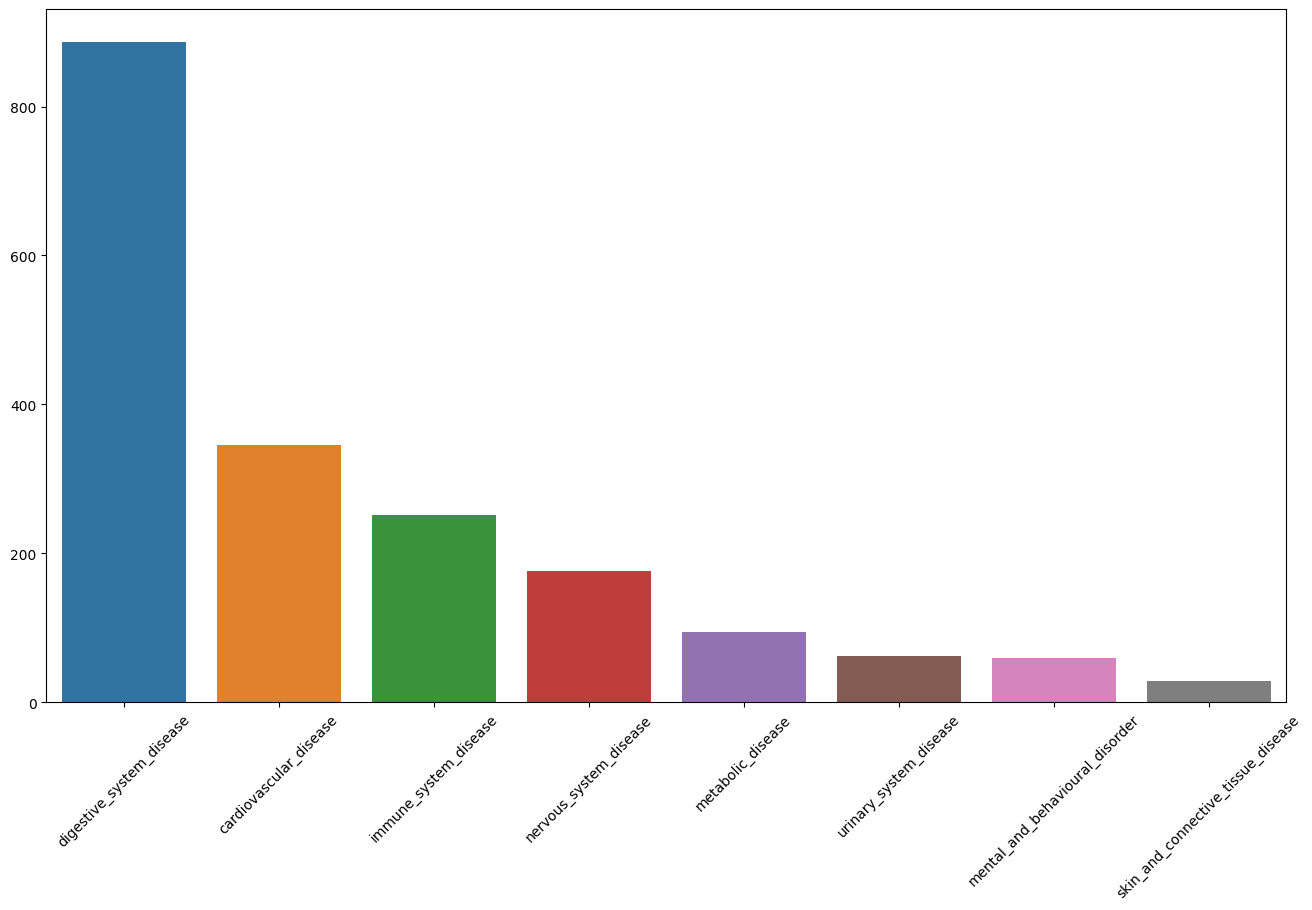

In [16]:
plt.figure(figsize=(16, 9))
sns.barplot(x=data['Disease'].value_counts().index, y=data['Disease'].value_counts().values)
plt.xticks(rotation=45)

In [17]:
data['Disease'].value_counts()

digestive_system_disease              886
cardiovascular_disease                345
immune_system_disease                 251
nervous_system_disease                177
metabolic_disease                      94
urinary_system_disease                 62
mental_and_behavioural_disorder        60
skin_and_connective_tissue_disease     29
Name: Disease, dtype: int64

In [18]:
data.to_csv('./drive/MyDrive/SCAMT/data_without_dupl.csv')